In [1314]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt

In [1418]:
#Getting data from binance
def getdailydata(symbol):
    client = Client()
    df = pd.DataFrame(client.get_historical_klines(f"{symbol}USDT",Client.KLINE_INTERVAL_1DAY,"2020-09-22","2022-03-22"))
    df = df[[0,1,2,3,4]]
    df = df.rename({0:"Date",1:f"{symbol}_Open",2:f"{symbol}_High",3:f"{symbol}_Low",4:f"{symbol}_Close"},axis = 1)
    df = df.set_index("Date")
    df.index = pd.to_datetime(df.index,unit = "ms")
    df = df.astype(float)
    
    return df
    

In [1419]:
#Data Cleaning
def data_cleaning(momentum_timeframe,symbols):
    df_Backtest = pd.DataFrame()
    for symbol in symbols:
        df = getdailydata(symbol)
        if df_Backtest.empty:
            df_Backtest = df
        else:
            df_Backtest = df_Backtest.join(df)
    for symbol in symbols:
        df_Backtest[f"{symbol}_price_movement_nD"] = (df_Backtest[f"{symbol}_Close"] - df_Backtest[f"{symbol}_Close"].shift(momentum_timeframe))/df_Backtest[f"{symbol}_Close"].shift(momentum_timeframe)
        df_Backtest[f"{symbol}_price_movement_1D"] = (df_Backtest[f"{symbol}_Close"] - df_Backtest[f"{symbol}_Close"].shift(1))/df_Backtest[f"{symbol}_Close"].shift(1)
    df_Backtest = df_Backtest.dropna()
    return df_Backtest


In [1420]:
def run_backtest(df,number_of_position,stop_loss,symbols):
    
    Portfolio_value = 10000
    i = 0 
    Long_list = []
    Short_list = []
    res = []
    
    while i < len(df):
        
        Bet = Portfolio_value/(number_of_position*2)

        if Long_list:
            for ticker in Long_list:
                if (df[f"{ticker}_Low"].iloc[i] - df[f"{ticker}_Close"].iloc[i-1])/df[f"{ticker}_Close"].iloc[i-1] < -1*stop_loss:
                    Portfolio_value += (Bet)*-stop_loss
                else:
                    Portfolio_value += (Bet)*(df[f"{ticker}_price_movement_1D"].iloc[i])
                    
            for ticker in Short_list:
                if (df[f"{ticker}_High"].iloc[i] - df[f"{ticker}_Close"].iloc[i-1])/df[f"{ticker}_Close"].iloc[i-1] > stop_loss:
                    Portfolio_value += (Bet)*-stop_loss
                else:
                    Portfolio_value += (Bet)*max((-df[f"{ticker}_price_movement_1D"].iloc[i]),-1)

        Dict = {}
        for symbol in symbols:
            Dict[symbol] = df_Backtest[f"{symbol}_price_movement_nD"].iloc[i]
        Return = sorted(Dict.items(), key=lambda item: item[1])
        
        Long_list = [Return[-j][0] for j in range(1,number_of_position+1)]
        Short_list = [Return[j][0] for j in range(number_of_position)]
        
        res.append(Portfolio_value)
        
        i += 1
        
    return res
        

In [1421]:
#Calculating max drawdown
def max_drawdown(res):
    Max = 0
    Max_drawdown = 0
    for i in res:
        Max = max(Max,i)
        Max_drawdown = min(0,Max_drawdown,(i - Max)/Max)
    return Max_drawdown

In [1422]:
#Backtest on two basket of cryptocurrencies
basket1 = ["ETH","BNB","SOL","AVAX","MATIC","LUNA","TRX"]
basket2 = ["ETH","BNB","SOL","AVAX","MATIC","LUNA","TRX","DOGE","XRP","LINK","ADA","LTC"]

df_Backtest = data_cleaning(momentum_timeframe = 14, symbols = basket2)
res = run_backtest(df_Backtest, number_of_position = 1,stop_loss = 1, symbols = basket2)

In [1425]:
end = dt.datetime(2022, 3, 22)
then = end - dt.timedelta(days=len(res))
days = mdates.drange(then,end,dt.timedelta(days=1))

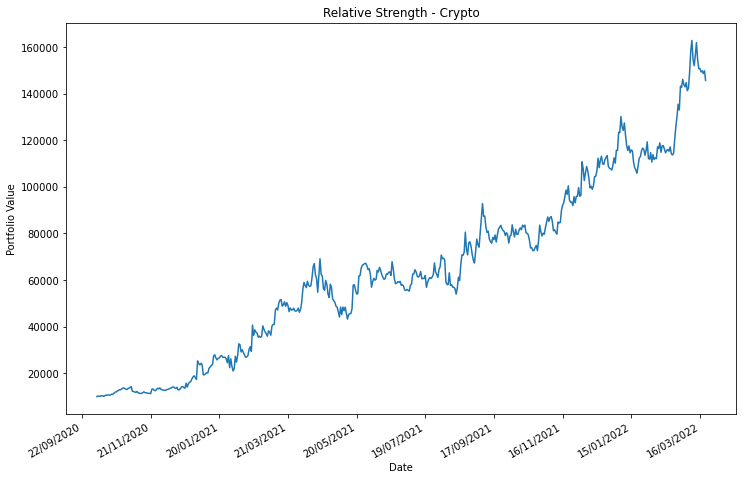

In [1426]:
plt.figure(figsize=(12, 8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.title("Relative Strength - Crypto")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.gcf().autofmt_xdate()
plt.plot(days,res)

In [1427]:
daily_return = [(res[i]-res[i-1])/res[i-1] for i in range(1,len(res))]

In [1428]:
sharpe_ratio = (np.array(daily_return).mean()/np.array(daily_return).std())*(len(res)**0.5)
print("Sharpe ratio = {:.2f}".format(sharpe_ratio))
Anuualized_Return = (res[-1]/res[0])**(365/len(res))
print("Annualized return = {:.2f}%".format((Anuualized_Return-1)*100))
Max_drawdown = max_drawdown(res)
print("Max drawdown = {:.2f}%".format(-Max_drawdown*100))


Sharpe ratio = 2.74
Annualized return = 526.24%
Max drawdown = 37.48%
